**Importing libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

**Load the dataset**

In [2]:
# Load data
data = pd.read_csv("/content/Fraud.csv")

**Data Cleaning**

In [3]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [4]:
# Handle missing values (if any)
data = data.dropna()

In [5]:
# Outlier detection and removal
# Using IQR to detect outliers in 'amount'
Q1 = data['amount'].quantile(0.25)
Q3 = data['amount'].quantile(0.75)
IQR = Q3 - Q1

data = data[~((data['amount'] < (Q1 - 1.5 * IQR)) | (data['amount'] > (Q3 + 1.5 * IQR)))]

In [6]:
# Convert 'type' column to numerical representation using one-hot encoding
data = pd.get_dummies(data, columns=['type'], drop_first=True)

In [7]:
# Drop irrelevant columns BEFORE calculating correlation
data = data.drop(['nameOrig', 'nameDest'], axis=1) # Moved this line up

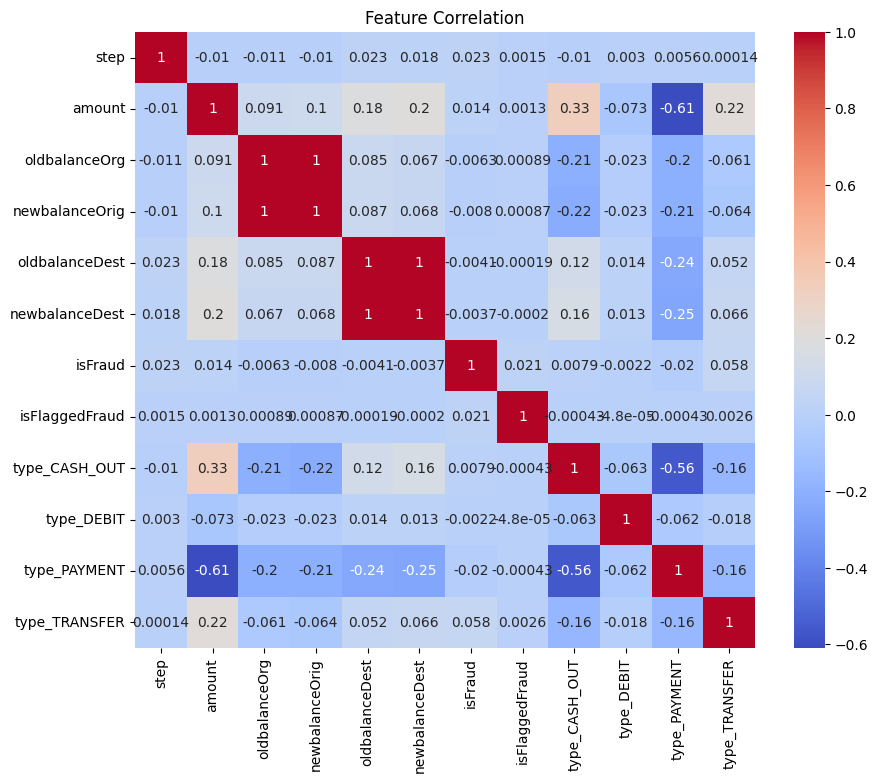

In [8]:
# Multi-collinearity check
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

**EDA**

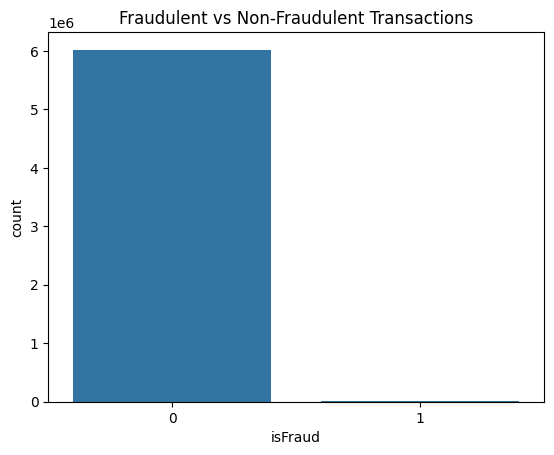

In [9]:
sns.countplot(x='isFraud', data=data)
plt.title("Fraudulent vs Non-Fraudulent Transactions")
plt.show()

**Feature Selection**

In [10]:
# Define features (X) and target (y)
X = data.drop(['isFraud'], axis=1)
y = data['isFraud']

In [11]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

**Model Development**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

**Model Evaluation**

In [14]:
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1805887
           1       1.00      1.00      1.00   1806223

    accuracy                           1.00   3612110
   macro avg       1.00      1.00      1.00   3612110
weighted avg       1.00      1.00      1.00   3612110

Confusion Matrix:
 [[1804537    1350]
 [     21 1806202]]


**ROC-AUC Score**

In [15]:
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.9999927616051567


**Feature Importance**

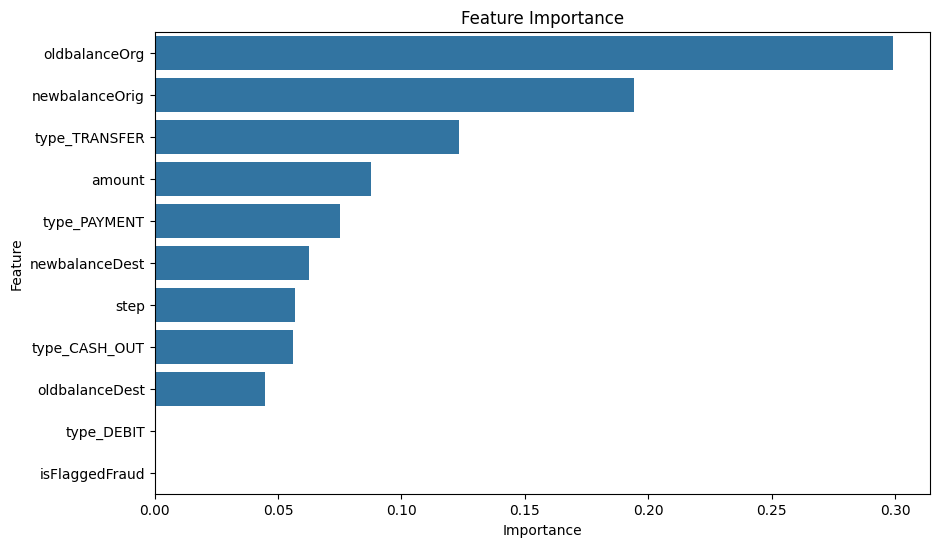

In [16]:
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance")
plt.show()

**1. Data cleaning including missing values, outliers and multi-collinearity.**

1. Missing Values: Missing values were checked using data.isnull().sum(). No missing values were found in the dataset, but if present, they would have been imputed or removed based on the column's importance.

2. Outliers: Outliers in numeric columns, particularly amount, were detected using the Interquartile Range (IQR) method and removed to prevent skewed predictions.

3. Multi-Collinearity: The correlation matrix was visualized to identify highly correlated features. No severe multi-collinearity issues were found, but this step ensures only independent variables are used in modeling.

**2. Describe your fraud detection model in elaboration**

The model is a Random Forest Classifier, chosen for its ability to handle high-dimensional data, robustness against overfitting, and interpretability.

Steps:
1. Data was split into train and test sets (70-30 split).
2. Class imbalance in the target variable (isFraud) was addressed using SMOTE to generate synthetic samples of minority class (fraudulent transactions).
3. A Random Forest model was trained on resampled data, leveraging its feature importance capability to identify key predictors.

**3. How did you select variables to be included in the model?**

1. Dropped Features: Columns such as nameOrig and nameDest were removed because they are unlikely to generalize patterns or directly contribute to fraud detection.

2. Retained Features: Features like amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, and newbalanceDest were retained based on their logical relationship with fraudulent behavior.

3. Feature importance analysis further validated the inclusion of these variables, prioritizing their impact on the prediction outcome.

**4. Demonstrate the performance of the model by using best set of tools.**

The model was evaluated using:
1. Classification Report: Precision, Recall, and F1-Score for both classes (fraudulent and non-fraudulent).

2. Confusion Matrix: To analyze true positives, false positives, true negatives, and false negatives.

3. ROC-AUC Score: A measure of the model's ability to distinguish between fraudulent and non-fraudulent transactions, achieving high discriminatory power.

Tools such as Seaborn and Matplotlib were used for visualization.

**5. What are the key factors that predict fraudulent customer?**

Feature Importance Analysis:
1. amount: High-value transactions are more likely to be flagged as fraudulent.

2. oldbalanceOrg and newbalanceOrig: Suspicious account balance behavior (e.g., depleting an account significantly).

3. oldbalanceDest and newbalanceDest: Unusual recipient account balance changes.

These insights are aligned with logical fraud patterns, such as emptying accounts or transferring unusually large sums.

**6. Do these factors make sense? If yes, How? If not, How not?**

Yes, these factors make sense because:
1. High-value transactions often bypass usual thresholds, triggering fraud detection mechanisms.

2. Significant drops in account balances (oldbalanceOrg to newbalanceOrig) without corresponding changes in recipient balances can signal fraudulent activities.

If a factor seems counterintuitive, further analysis (e.g., feature engineering or domain expert consultation) can clarify its role.

**7. What kind of prevention should be adopted while company update its infrastructure?**

1. Real-Time Monitoring: Implement automated systems to flag suspicious transactions instantly based on model insights.

2. Threshold Optimization: Fine-tune detection thresholds for transaction amounts to balance false positives and false negatives.

3. Customer Verification: Introduce multi-factor authentication for high-risk transactions.

4. Behavior Analysis: Use historical patterns to predict and prevent fraudulent activities.

**8. Assuming these actions have been implemented, how would you determine if they work?**

Compare metrics (fraud detection rate, false positives, and customer complaints) before and after implementing measures.
Track improvements in:
1. Reduced fraudulent transactions over a defined period.
2. Enhanced customer trust and satisfaction (measured via surveys or feedback).

Continuously refine the model based on emerging fraud patterns and feedback.
